import /content/drive/MyDrive/v2x_data/veremi_stratified_200000.zip

In [10]:
from datetime import datetime

# Get current date and time
now = datetime.now()

# Print formatted datetime
print("Current date and time:", now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time: 2025-06-15 16:52:18


In [1]:
from google.colab import files

# Upload the kaggle.json file that you downloaded
uploaded = files.upload()

# Move the kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
# Install the Kaggle library
!pip install kaggle

# Download the dataset
!kaggle datasets download -d shilpasayura/veremi-extension-simple

# Unzip the dataset
!unzip veremi-extension-simple.zip


Dataset URL: https://www.kaggle.com/datasets/shilpasayura/veremi-extension-simple
License(s): CC0-1.0
 50% 111M/220M [00:00<00:00, 1.16GB/s]
100% 220M/220M [00:00<00:00, 461MB/s] 
Archive:  veremi-extension-simple.zip
  inflating: veremi_extension_simple.csv  


In [3]:
import pandas as pd

# Load the dataset
#df = pd.read_csv('/root/dataset/veremi_extension_simple.csv')

df = pd.read_csv('/content/veremi_extension_simple.csv')

# Display the first few rows of the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3194808 entries, 0 to 3194807
Data columns (total 20 columns):
 #   Column        Dtype  
---  ------        -----  
 0   type          int64  
 1   sendTime      float64
 2   sender        int64  
 3   senderPseudo  int64  
 4   messageID     int64  
 5   class         int64  
 6   posx          float64
 7   posy          float64
 8   posz          float64
 9   spdx          float64
 10  spdy          float64
 11  spdz          float64
 12  aclx          float64
 13  acly          float64
 14  aclz          float64
 15  hedx          float64
 16  hedy          float64
 17  hedz          float64
 18  Attack        object 
 19  Attack_type   object 
dtypes: float64(13), int64(5), object(2)
memory usage: 487.5+ MB


In [4]:
df['Attack_type'].value_counts()

,count
Attack_type,
Normal behavior,1900539
DoS random sybil,175391
Unknown,168983
DoS disruptive,131305
Traffic congestion sybil,129270
Data replay sybil,126724
Constant speed offset,44359
DoS,44337
DoS disruptive sybil,44310


In [5]:
# Create a table with counts for each combination of 'class', 'Attack', and 'Attack_type'
class_attack_summary = df.groupby(['class', 'Attack', 'Attack_type']).size().reset_index(name='count')

# Display the result
print(class_attack_summary)


    class  Attack               Attack_type    count
0       0  Normal           Normal behavior  1900539
1       1   Fault         Constant position    43653
2       2   Fault  Constant position offset    43567
3       3   Fault           Random position    43857
4       4   Fault    Random position offset    42575
5       5   Fault            Constant speed    41925
6       6   Fault     Constant speed offset    44359
7       7   Fault              Random speed    42258
8       8   Fault       Random speed offset    42583
9       9  Attack                Disruptive    42790
10     10  Attack               Data replay    43264
11     11  Attack                       DoS    44337
12     12  Attack                DoS random    43118
13     13  Attack            DoS disruptive   131305
14     14  Attack         Data replay sybil   126724
15     15  Attack  Traffic congestion sybil   129270
16     16  Attack          DoS random sybil   175391
17     17  Attack      DoS disruptive sybil   

In [6]:
import pandas as pd

# Load your dataset (replace with your actual file path if needed)
# df = pd.read_csv('veremi_dataset.csv')

# Step 1: Define classes to keep
normal_class = [0]
attack_classes = list(range(9, 18))  # Classes 9 to 17 are labeled attacks

# Step 2: Filter the dataset
df_binary = df[df['class'].isin(normal_class + attack_classes)].copy()

# Step 3: Create a new binary label column
# 0 = Normal, 1 = Attack
df_binary['binary_label'] = df_binary['class'].apply(lambda x: 0 if x == 0 else 1)

# Step 4: Check class distribution
print("Binary Class Distribution:")
print(df_binary['binary_label'].value_counts())

print("\nTotal Records after Filtering:")
print(len(df_binary))
# Result: df_binary is now ready for binary classification modeling


Binary Class Distribution:
binary_label
0    1900539
1     780509
Name: count, dtype: int64

Total Records after Filtering:
2681048


In [8]:
# Create a table with counts for each combination of 'class', 'Attack', and 'Attack_type'
class_attack_summary = df_binary.groupby(['class', 'Attack', 'Attack_type']).size().reset_index(name='count')

# Display the result
print(class_attack_summary)

   class  Attack               Attack_type    count
0      0  Normal           Normal behavior  1900539
1      9  Attack                Disruptive    42790
2     10  Attack               Data replay    43264
3     11  Attack                       DoS    44337
4     12  Attack                DoS random    43118
5     13  Attack            DoS disruptive   131305
6     14  Attack         Data replay sybil   126724
7     15  Attack  Traffic congestion sybil   129270
8     16  Attack          DoS random sybil   175391
9     17  Attack      DoS disruptive sybil    44310


In [11]:
# Step 1: Split normal and attack records
df_normal = df_binary[df_binary['binary_label'] == 0]
df_attack = df_binary[df_binary['binary_label'] == 1]

# Step 2: Downsample normal class to match attack count
n_attack = len(df_attack)
df_normal_balanced = df_normal.sample(n=n_attack, random_state=42)

# Step 3: Stratified sampling of attack classes (no deprecated behavior)
attack_counts = df_attack['class'].value_counts(normalize=True)

df_attack_balanced = pd.concat([
    df_attack[df_attack['class'] == cls].sample(
        n=int(n_attack * frac), random_state=42
    )
    for cls, frac in attack_counts.items()
])

# Step 4: Combine and shuffle
from sklearn.utils import shuffle
df_balanced_binary = shuffle(
    pd.concat([df_normal_balanced, df_attack_balanced]),
    random_state=42
).reset_index(drop=True)

# Step 5: Confirm balance
print(" Binary class distribution:")
print(df_balanced_binary['binary_label'].value_counts())

print("\n Attack class distribution:")
print(df_balanced_binary[df_balanced_binary['binary_label'] == 1]['class'].value_counts(normalize=True))


 Binary class distribution:
binary_label
1    780509
0    780509
Name: count, dtype: int64

 Attack class distribution:
class
16    0.224714
13    0.168230
15    0.165623
14    0.162361
11    0.056805
17    0.056771
10    0.055430
12    0.055243
9     0.054823
Name: proportion, dtype: float64


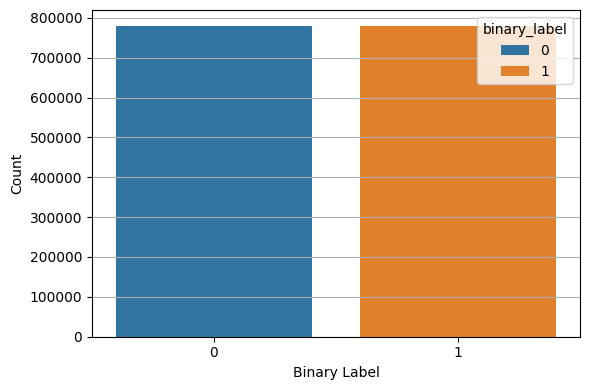

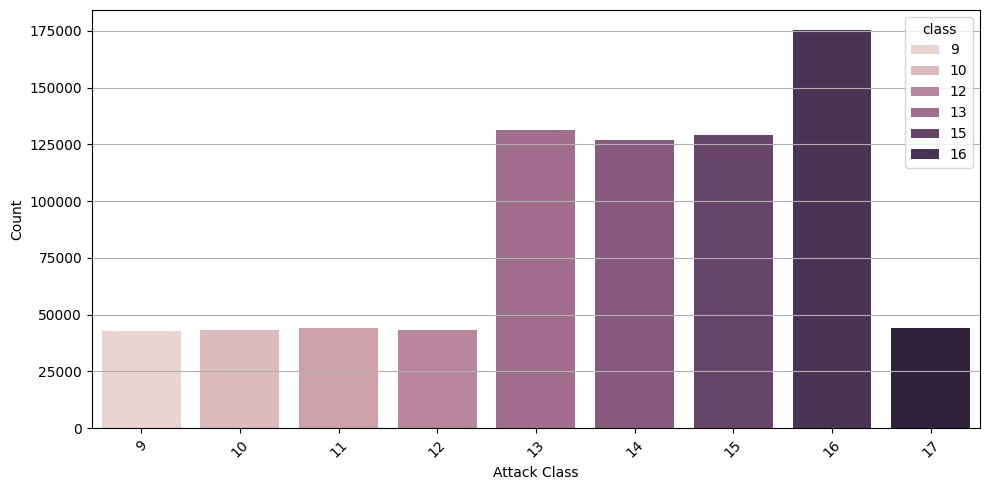

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Binary class distribution (Normal vs Attack)
plt.figure(figsize=(6, 4))
sns.countplot(data=df_balanced_binary, x='binary_label', hue='binary_label')
#plt.title('Balanced Binary Label Distribution (0 = Normal, 1 = Attack)', fontsize=12)
plt.xlabel('Binary Label')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("balanced_binary_distribution.png", dpi=300)
plt.show()

# Attack class distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df_balanced_binary[df_balanced_binary['binary_label'] == 1],
              x='class', hue='class')
#plt.title('Attack Class Distribution (within Attacks)', fontsize=12)
plt.xlabel('Attack Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("attack_class_distribution.png", dpi=300)
plt.show()


Saved veremi_stratified_20000.csv with 20000 records
20000
binary_label
0    10000
1    10000
Name: count, dtype: int64
class
0     10000
16     2249
13     1682
15     1656
14     1624
11      568
17      567
10      554
12      552
9       548
Name: count, dtype: int64


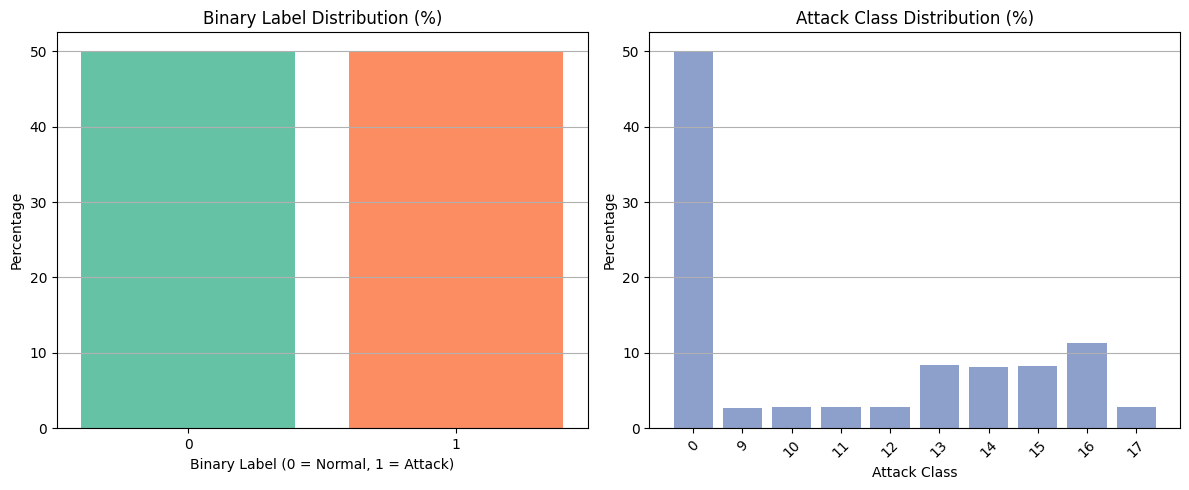

Saved veremi_stratified_40000.csv with 40000 records
40000
binary_label
0    20000
1    20000
Name: count, dtype: int64
class
0     20000
16     4494
13     3365
15     3313
14     3248
11     1136
17     1135
10     1108
12     1105
9      1096
Name: count, dtype: int64


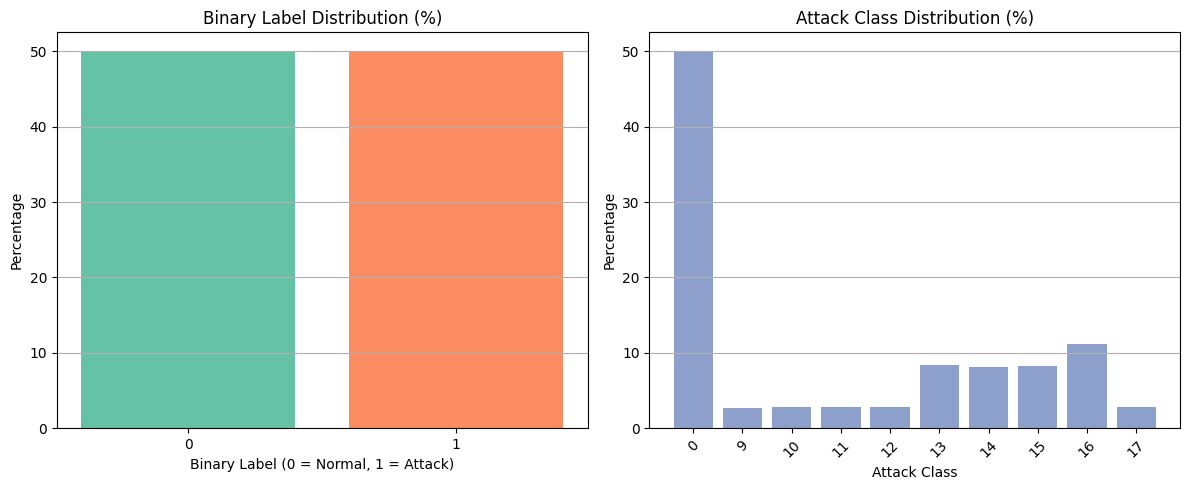

Saved veremi_stratified_80000.csv with 80000 records
80000
binary_label
0    40000
1    40000
Name: count, dtype: int64
class
0     40000
16     8990
13     6730
15     6624
14     6495
11     2272
17     2270
10     2217
12     2209
9      2193
Name: count, dtype: int64


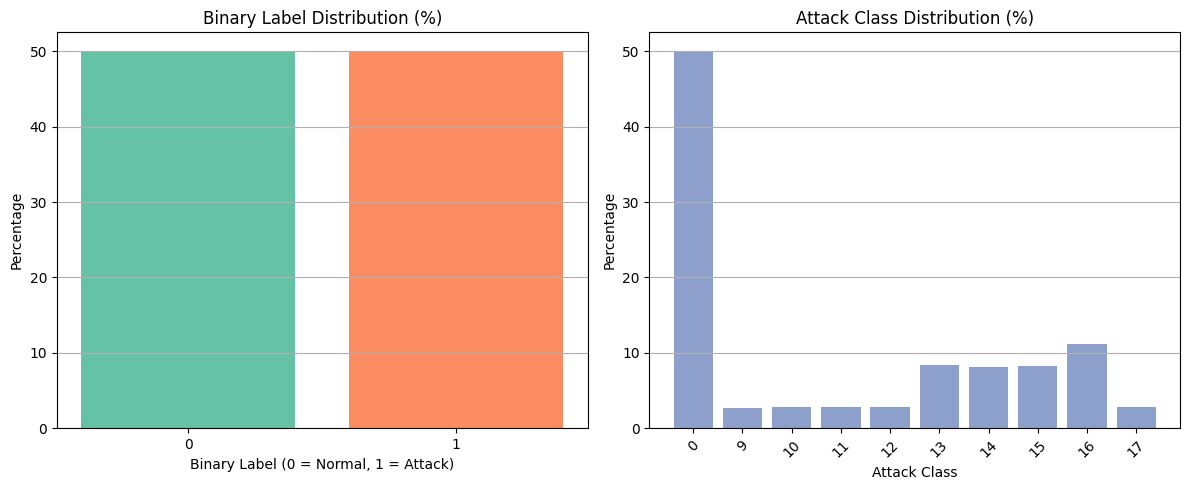

Saved veremi_stratified_120000.csv with 120000 records
120000
binary_label
0    60000
1    60000
Name: count, dtype: int64
class
0     60000
16    13485
13    10094
15     9937
14     9741
11     3408
17     3406
10     3326
12     3314
9      3289
Name: count, dtype: int64


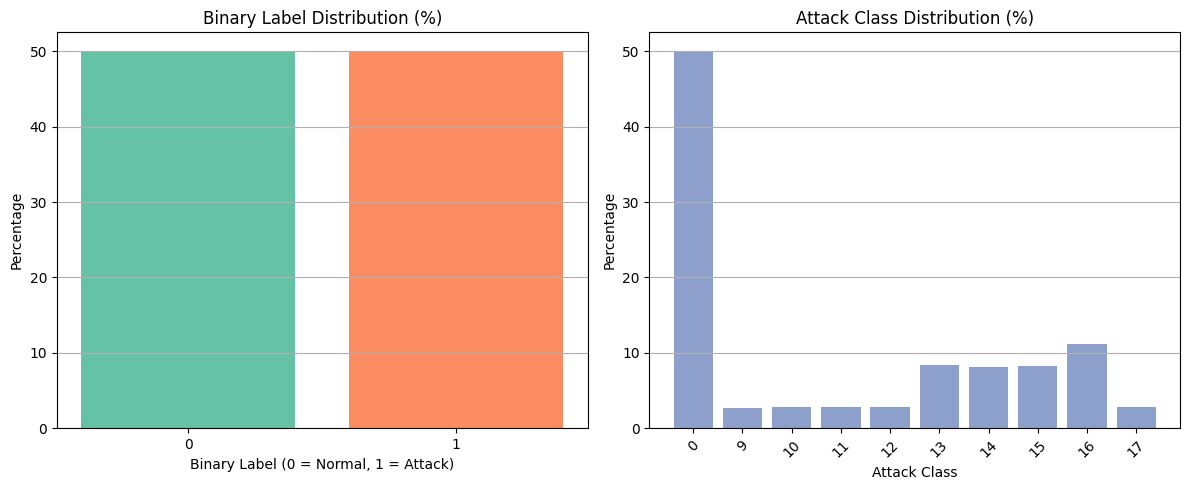

Saved veremi_stratified_160000.csv with 160000 records
160000
binary_label
0    80000
1    80000
Name: count, dtype: int64
class
0     80000
16    17978
13    13459
15    13249
14    12990
11     4544
17     4541
10     4434
12     4419
9      4386
Name: count, dtype: int64


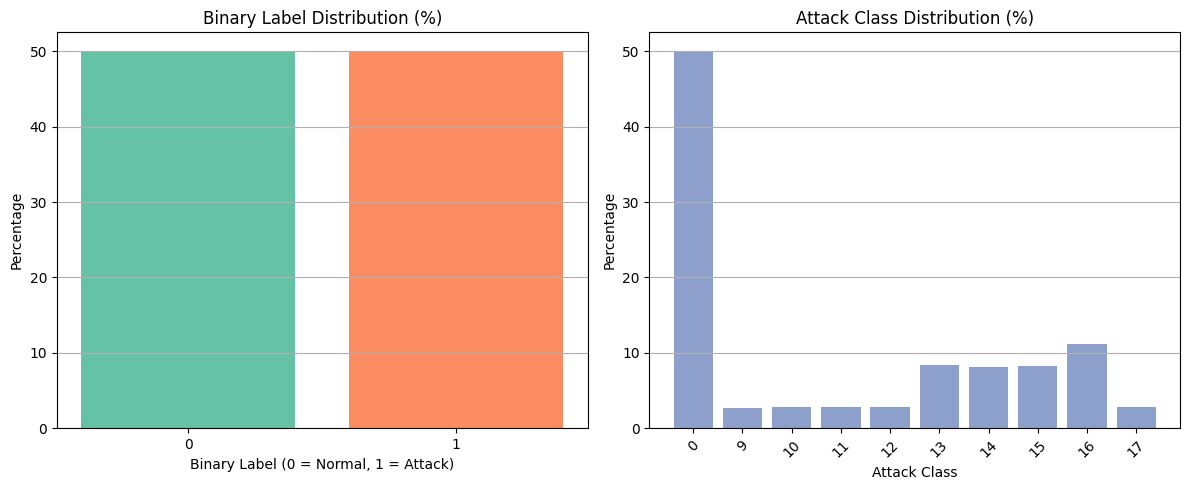

Saved veremi_stratified_200000.csv with 200000 records
200000
binary_label
0    100000
1    100000
Name: count, dtype: int64
class
0     100000
16     22471
13     16823
15     16562
14     16237
11      5681
17      5677
10      5543
12      5524
9       5482
Name: count, dtype: int64


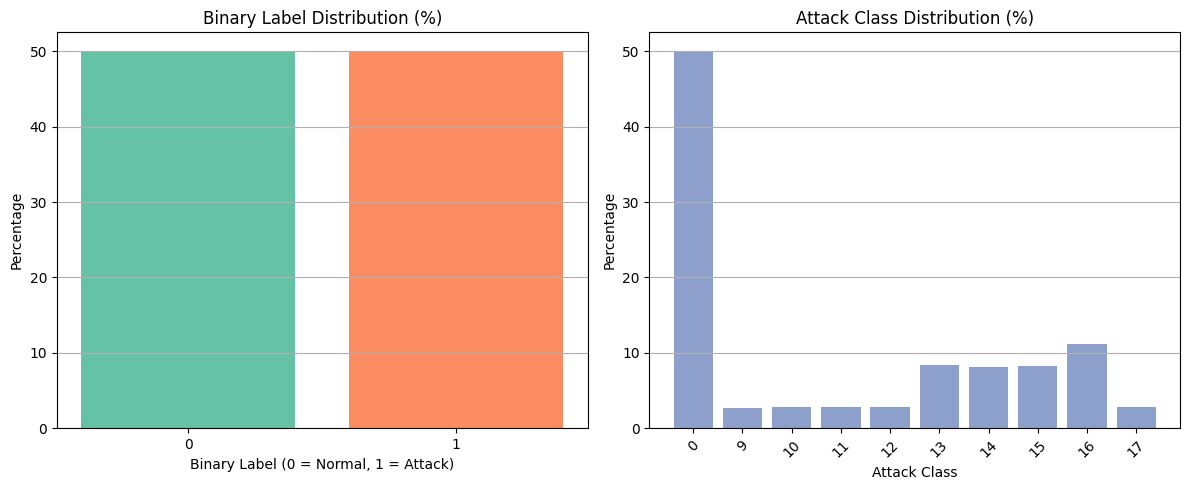

In [13]:
from sklearn.utils import shuffle


subset_sizes = [20000, 40000, 80000, 120000, 160000, 200000]

df_normal = df_balanced_binary[df_balanced_binary['binary_label'] == 0]
df_attack = df_balanced_binary[df_balanced_binary['binary_label'] == 1]

attack_class_proportions = df_attack['class'].value_counts(normalize=True)

for size in subset_sizes:
    n_attack = size // 2
    n_normal = size // 2

    # Sample attack data proportionally without exceeding available count
    attack_samples = []
    for cls, frac in attack_class_proportions.items():
        cls_pool = df_attack[df_attack['class'] == cls]
        n_cls = min(len(cls_pool), int(n_attack * frac))
        attack_samples.append(cls_pool.sample(n=n_cls, random_state=42))
    attack_subset = pd.concat(attack_samples)

    # If slightly under n_attack due to rounding, sample extra from full attack pool
    if len(attack_subset) < n_attack:
        remaining = n_attack - len(attack_subset)
        extra = df_attack.drop(attack_subset.index).sample(n=remaining, random_state=42)
        attack_subset = pd.concat([attack_subset, extra])

    # Sample normal records
    normal_subset = df_normal.sample(n=n_normal, random_state=42)

    # Combine and shuffle
    df_subset = shuffle(pd.concat([attack_subset, normal_subset]), random_state=42).reset_index(drop=True)

    # Save to file
    df_subset.to_csv(f'veremi_stratified_{size}.csv', index=False)
    print(f"Saved veremi_stratified_{size}.csv with {len(df_subset)} records")
    print(len(df_subset))
    print(df_subset["binary_label"].value_counts())
    print(df_subset["class"].value_counts())

    # Compute percentages
    binary_counts = df_subset['binary_label'].value_counts(normalize=True) * 100
    class_counts = df_subset['class'].value_counts(normalize=True) * 100

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].bar(binary_counts.index.astype(str), binary_counts.values, color=['#66c2a5', '#fc8d62'])
    axes[0].set_title('Binary Label Distribution (%)')
    axes[0].set_xlabel('Binary Label (0 = Normal, 1 = Attack)')
    axes[0].set_ylabel('Percentage')
    axes[0].grid(axis='y')

    class_counts_sorted = class_counts.sort_index()
    axes[1].bar(class_counts_sorted.index.astype(str), class_counts_sorted.values, color='#8da0cb')
    axes[1].set_title('Attack Class Distribution (%)')
    axes[1].set_xlabel('Attack Class')
    axes[1].set_ylabel('Percentage')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y')

    plt.tight_layout()
    plt.show()


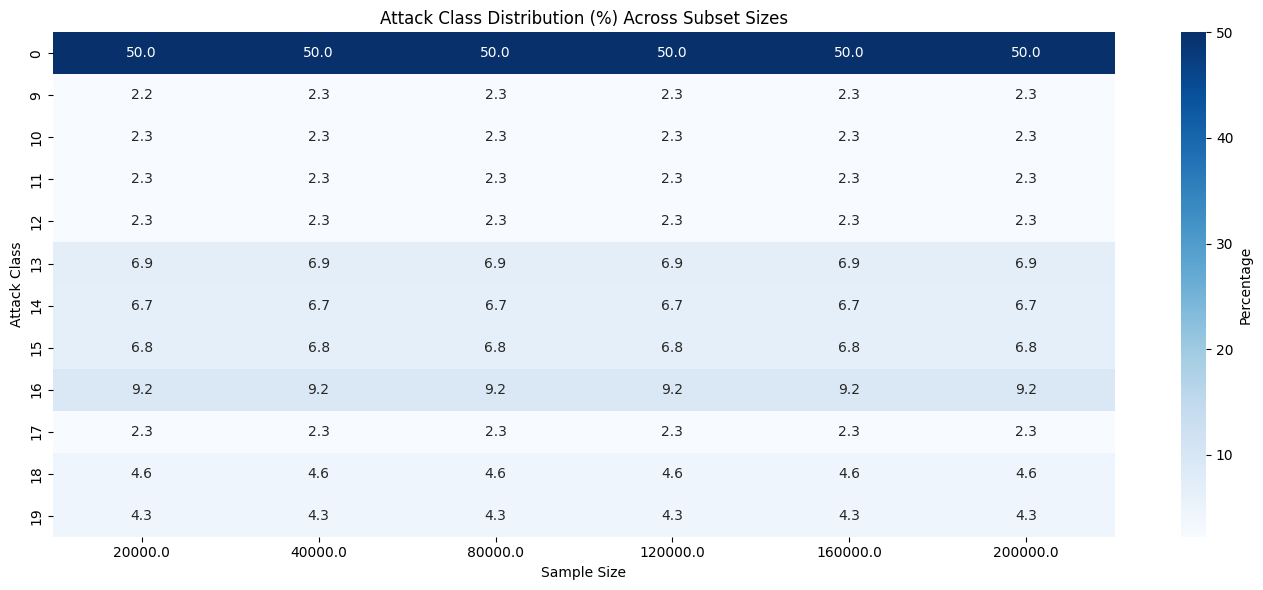

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.heatmap(subset_class_summary.T, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Percentage'})

plt.title("Attack Class Distribution (%) Across Subset Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Attack Class")
plt.tight_layout()
plt.show()


## LSTM TESTING 20000

In [14]:
# STEP 1: Install TensorFlow (only once)
!pip install tensorflow


In [15]:
import pandas as pd

df = pd.read_csv('/content/veremi_stratified_20000.csv')
df.info()
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          20000 non-null  int64  
 1   sendTime      20000 non-null  float64
 2   sender        20000 non-null  int64  
 3   senderPseudo  20000 non-null  int64  
 4   messageID     20000 non-null  int64  
 5   class         20000 non-null  int64  
 6   posx          20000 non-null  float64
 7   posy          20000 non-null  float64
 8   posz          20000 non-null  float64
 9   spdx          20000 non-null  float64
 10  spdy          20000 non-null  float64
 11  spdz          20000 non-null  float64
 12  aclx          20000 non-null  float64
 13  acly          20000 non-null  float64
 14  aclz          20000 non-null  float64
 15  hedx          20000 non-null  float64
 16  hedy          20000 non-null  float64
 17  hedz          20000 non-null  float64
 18  Attack        20000 non-nu

,type,sendTime,sender,senderPseudo,messageID,class,posx,posy,posz,spdx,...,spdz,aclx,acly,aclz,hedx,hedy,hedz,Attack,Attack_type,binary_label
0,4,75326.512233,136377,101363777,439670532,0,480.933820,300.737308,0.0,12.825311,...,0.0,0.082334,0.028778,0.0,0.947018,0.321181,0.0,Normal,Normal behavior,0
1,4,43542.926181,56595,30565954,167944870,16,482.101444,293.050763,0.0,-0.767192,...,0.0,-0.770453,-0.265936,0.0,-0.988207,0.153127,0.0,Attack,DoS random sybil,1
2,4,22413.480458,5355,1053552,7444247,10,407.316252,268.455971,0.0,-12.194018,...,0.0,-0.308649,-0.103598,0.0,-0.976396,0.215987,0.0,Attack,Data replay,1
3,4,50821.632967,73695,1,225685977,16,224.507629,883.159479,0.0,0.550523,...,0.0,0.526439,-3.395347,0.0,0.171130,0.985249,0.0,Attack,DoS random sybil,1
4,4,39928.864571,51741,10517413,157440891,0,447.690155,289.285102,0.0,10.316341,...,0.0,-0.324897,-0.112177,0.0,0.957584,0.288153,0.0,Normal,Normal behavior,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4,55080.069716,79881,10798815,240877717,0,608.121943,686.472401,0.0,0.001591,...,0.0,0.000296,0.000296,0.0,0.924011,0.382366,0.0,Normal,Normal behavior,0
19996,4,66021.747050,107439,101074396,332822536,0,814.920629,405.806237,0.0,-10.561223,...,0.0,-1.841610,-0.640292,0.0,-0.983608,-0.180318,0.0,Normal,Normal behavior,0
19997,4,25379.704760,10851,10108512,19405918,15,718.560844,680.763720,0.0,11.200304,...,0.0,1.088217,0.931841,0.0,-0.279551,-0.984750,0.0,Attack,Traffic congestion sybil,1
19998,4,24212.972317,8331,5083312,13032621,16,997.851834,928.279713,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.984116,0.177529,0.0,Attack,DoS random sybil,1


preprocessing pipeline

* Loads the CSV
* Drops irrelevant columns
* Normalizes with StandardScaler
* Reshapes for LSTM
* Splits into train/test sets
* Returns all ready-to-train arrays

In [16]:
# STEP 2: Imports
import pandas as pd
import numpy as np
import time
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense


In [17]:
# STEP 3: Load or Initialize Results DataFrame
try:
    results_df = pd.read_csv("/content/lstmgruatt2_test_results.csv")
    print("Loaded previous results")
except FileNotFoundError:
    results_df = pd.DataFrame(columns=[
        'Timestamp', 'Model', 'Dataset', 'Sample Size', 'Training Time (s)', 'Best Epoch','Accuracy', 'Precision', 'Recall', 'F1 Score',
        'Confusion Matrix', 'CPU Usage (%)', 'Memory Usage (MB)', 'Model Size (MB)', 'Inference Time (s)'
    ])
    print("Created new results table")

Created new results table


* 90:5:5 train/val/test split
* Validation accuracy tracking
* Early stopping to prevent overfitting
* Train/validation loss/accuracy plots

In [18]:
def prepare_dataset(file_path, random_state=42):
  # Single time step
    df = pd.read_csv(file_path)
    drop_cols = ['Attack', 'Attack_type', 'class', 'binary_label', 'messageID', 'sender', 'senderPseudo']
    X = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    if 'binary_label' not in df.columns:
        raise ValueError("binary_label column missing in dataset.")

    y = df['binary_label'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.10, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)

    # For LSTM/GRU: (samples, timesteps=1, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_val, X_test, y_train, y_val, y_test, X_train.shape[2]


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Concatenate, Attention, GlobalAveragePooling1D

def create_lstm_gru_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM branch
    lstm_out = LSTM(64, return_sequences=True)(inputs)

    # GRU branch
    gru_out = GRU(64, return_sequences=True)(inputs)

    # Combine both branches
    combined = Concatenate(axis=-1)([lstm_out, gru_out])

    # Attention mechanism
    attn_out = Attention()([combined, combined])  # Self-attention returns (batch, time, features)

    # Flatten the sequence: collapse time dimension
    x = GlobalAveragePooling1D()(attn_out)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, x)
    return model


In [20]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt
import psutil
import time
import numpy as np
import os

def train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, dataset_name, sample_size, results_df):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    model_path = f'{sample_size}_{xModel}_mcp_{timestamp}.keras'
    if xModel == "LSTMGRU_ATT":
        model = create_lstm_gru_attention_model((X_train.shape[1], X_train.shape[2]))
    else:
        raise ValueError(f"Unknown model type: {xModel}")

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

    # Training
    train_start = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    training_time = time.time() - train_start

    # Load best checkpoint
    model = load_model(model_path)

    # Inference
    infer_start = time.time()
    y_pred_prob = model.predict(X_test).ravel()
    inference_time = (time.time() - infer_start) / len(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    best_epoch = np.argmin(history.history['val_loss']) + 1
    patience_used = len(history.history['val_loss']) - best_epoch

    cpu_usage = psutil.cpu_percent(interval=1)
    memory_usage = psutil.virtual_memory().used / (1024 ** 2)
    model_size = os.path.getsize(model_path) / (1024 * 1024)

    # Log results
    results_df.loc[len(results_df)] = {
        'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Model': xModel,
        'Dataset': dataset_name,
        'Sample Size': sample_size,
        'Training Time (s)': round(training_time, 2),
        'Best Epoch': best_epoch,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Confusion Matrix': str(cm),
        'CPU Usage (%)': cpu_usage,
        'Memory Usage (MB)': round(memory_usage, 2),
        'Model Size (MB)': model_size,
        'Inference Time (s)': round(inference_time, 6)
    }

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axvline(x=best_epoch - 1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.axvline(x=best_epoch - 1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Early stopping triggered. Best epoch: {best_epoch}, patience used: {patience_used}")
    print(f"Best model saved to: {model_path}")

    return results_df, cm


In [21]:
import matplotlib.pyplot as plt

def save_and_visualize_results(results_df, xmarker='o', save_path="lstmgru2_test_results.csv"):
    # Save to CSV
    results_df.to_csv(save_path, index=False)
    print(f"Results saved to {save_path}")

    # Plot selected metrics as markers only (no connecting lines)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        plt.scatter(results_df['Sample Size'], results_df[metric], marker=xmarker, label=metric)

    plt.xlabel("Sample Size")
    plt.ylabel("Score")
    plt.title("LSTM Classification Metrics by Sample Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display last result row
    from IPython.display import display
    display(results_df.tail(1))

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels, title, filename):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)   #Save the image
    plt.show()              # Show inline
    plt.close()             # Clean up the figure



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 64)     │     20,224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 1, 64)     │     15,360 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 128)    │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 128)    │          0 │ concatenate[0][0… │
│ (Attention)         │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,953 (179.50 KB)

 Trainable params: 45,953 (179.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5958 - loss: 0.6403
Epoch 1: val_loss improved from inf to 0.57556, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_17-01-29.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5963 - loss: 0.6399 - val_accuracy: 0.6880 - val_loss: 0.5756
Epoch 2/50
273/282 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6812 - loss: 0.5779
Epoch 2: val_loss improved from 0.57556 to 0.56053, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_17-01-29.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6812 - loss: 0.5778 - val_accuracy: 0.6980 - val_loss: 0.5605
Epoch 3/50
278/282 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6905 - loss: 0.5657
Epoch 3: val_loss improved from 0.56053 to 0.55641, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_17-01-29.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6905 - loss: 0.5657 - val_accuracy: 0.7070 - val_loss: 0.5564
Epoch 4/50
278/282 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


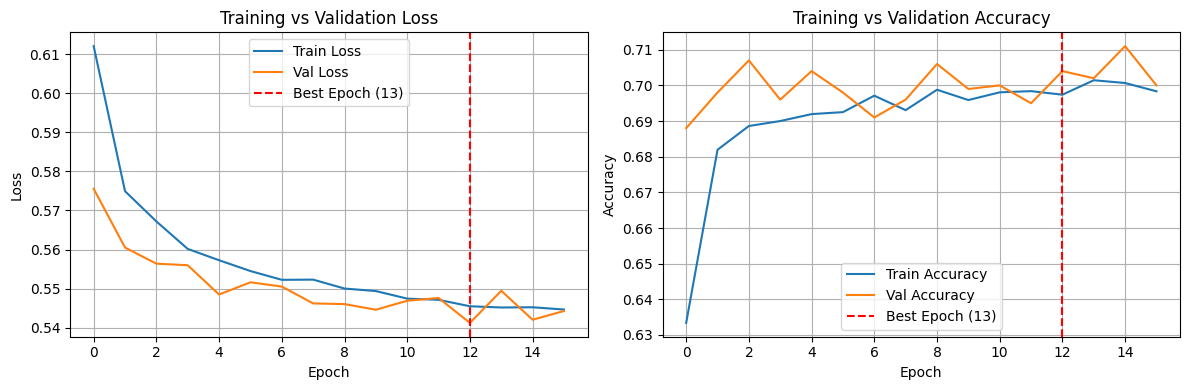

Early stopping triggered. Best epoch: 13, patience used: 3
Best model saved to: 14_LSTMGRU_ATT_mcp_2025-06-15_17-01-29.keras
Results saved to lstmgru2_test_results.csv


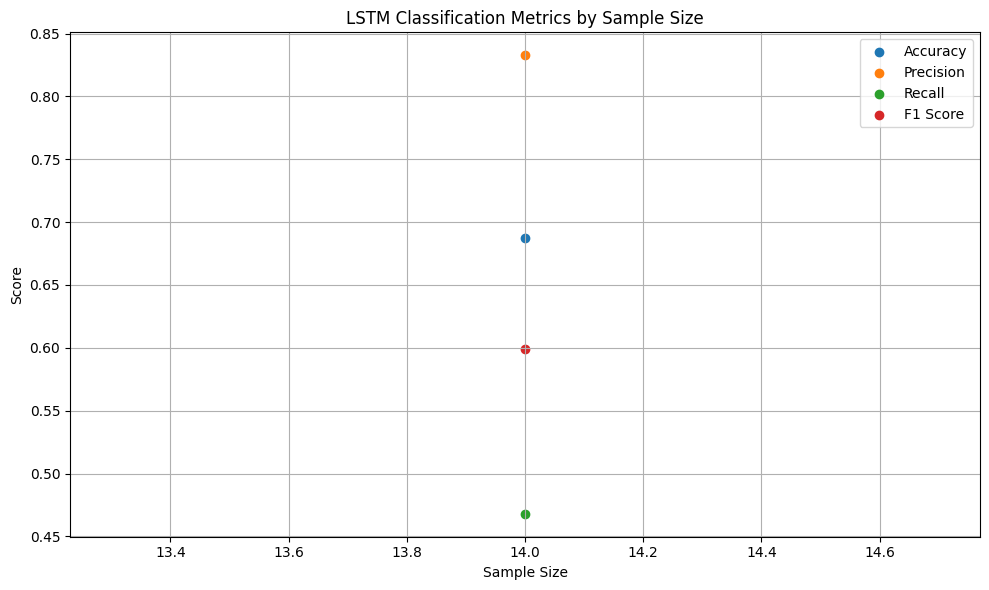

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
0,2025-06-15 17:02:16,LSTMGRU_ATT,veremi_stratified_20000.csv,14,43.91,13,0.687,0.83274,0.468,0.599232,[[453 47]\n [266 234]],2.5,2779.62,0.578823,0.001249


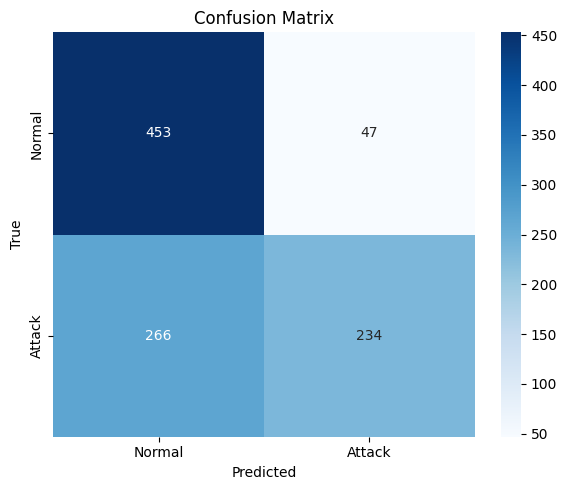

In [23]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_20000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'o')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 1, 64)     │     20,224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 1, 64)     │     15,360 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1, 128)    │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 1, 128)    │          0 │ concatenate_1[0]… │
│ (Attention)         │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_1[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,953 (179.50 KB)

 Trainable params: 45,953 (179.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


558/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6388 - loss: 0.6143
Epoch 1: val_loss improved from inf to 0.56293, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_17-05-58.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6390 - loss: 0.6141 - val_accuracy: 0.6975 - val_loss: 0.5629
Epoch 2/50
554/563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6870 - loss: 0.5663
Epoch 2: val_loss improved from 0.56293 to 0.54997, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_17-05-58.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6870 - loss: 0.5663 - val_accuracy: 0.6990 - val_loss: 0.5500
Epoch 3/50
551/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6916 - loss: 0.5580
Epoch 3: val_loss improved from 0.54997 to 0.54657, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_17-05-58.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6916 - loss: 0.5580 - val_accuracy: 0.6990 - val_loss: 0.5466
Epoch 4/50
554/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


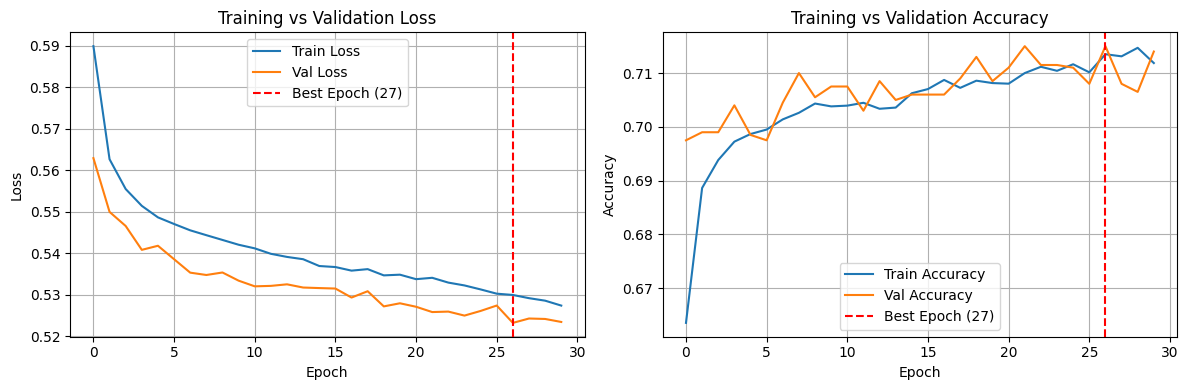

Early stopping triggered. Best epoch: 27, patience used: 3
Best model saved to: 14_LSTMGRU_ATT_mcp_2025-06-15_17-05-58.keras
Results saved to lstmgru2_test_results.csv


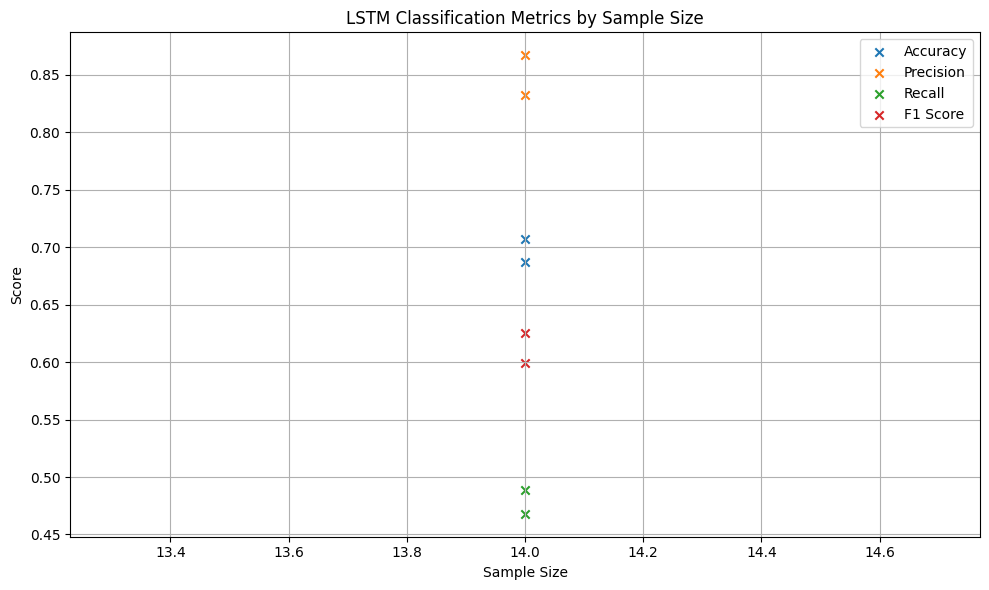

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
1,2025-06-15 17:07:49,LSTMGRU_ATT,veremi_stratified_40000.csv,14,108.88,27,0.707,0.867021,0.489,0.62532,[[925 75]\n [511 489]],23.9,2861.74,0.578876,0.000662


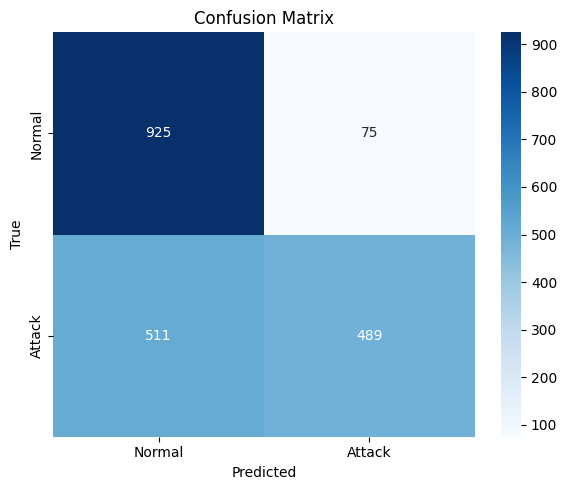

In [24]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_40000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_40000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'x')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 1, 64)     │     20,224 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 1, 64)     │     15,360 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1, 128)    │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 1, 128)    │          0 │ concatenate_2[0]… │
│ (Attention)         │                   │            │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_2[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         33 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,953 (179.50 KB)

 Trainable params: 45,953 (179.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6482 - loss: 0.5956

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.56718, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_17-09-14.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6484 - loss: 0.5955 - val_accuracy: 0.6740 - val_loss: 0.5672
Epoch 2/50
1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6935 - loss: 0.5556
Epoch 2: val_loss improved from 0.56718 to 0.55626, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_17-09-14.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6935 - loss: 0.5555 - val_accuracy: 0.6905 - val_loss: 0.5563
Epoch 3/50
1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6972 - loss: 0.5499
Epoch 3: val_loss did not improve from 0.55626
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6972 - loss: 0.5498 - val_accuracy: 0.6915 - val_loss: 0.5573
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7045 - loss: 0.5422
Epoch 4: val_loss improved from 0.55626 to 0.55459, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_17-09-14.ke

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


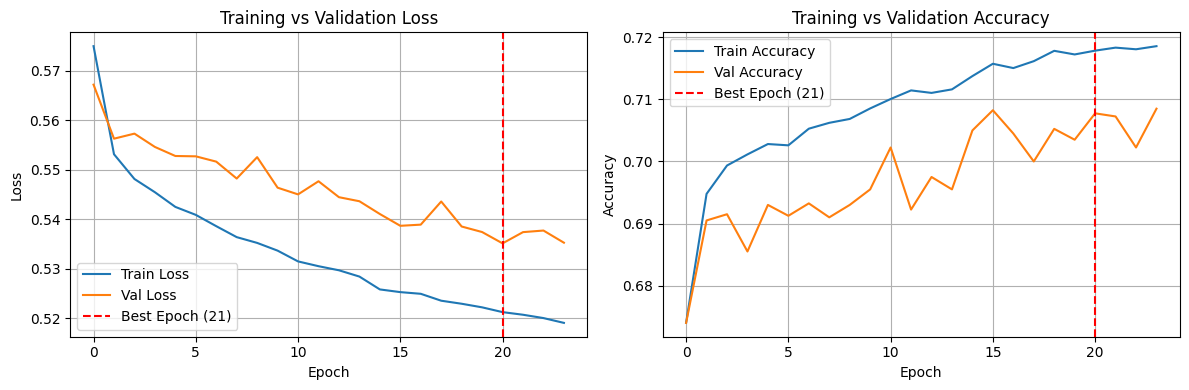

Early stopping triggered. Best epoch: 21, patience used: 3
Best model saved to: 14_LSTMGRU_ATT_mcp_2025-06-15_17-09-14.keras
Results saved to lstmgru2_test_results.csv


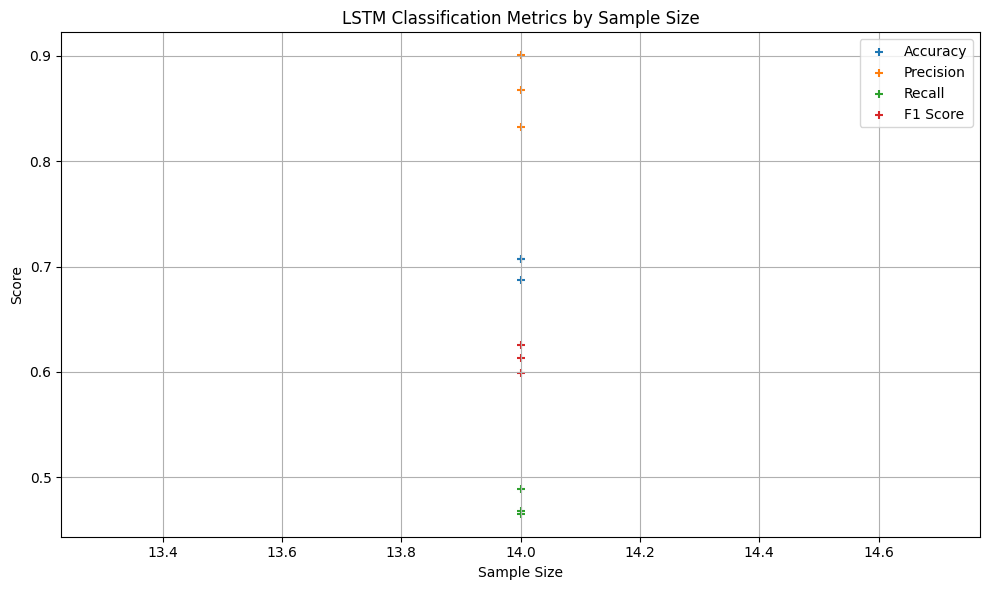

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
2,2025-06-15 17:12:07,LSTMGRU_ATT,veremi_stratified_80000.csv,14,171.04,21,0.707,0.900387,0.4655,0.613711,[[1897 103]\n [1069 931]],2.5,2914.78,0.578876,0.000164


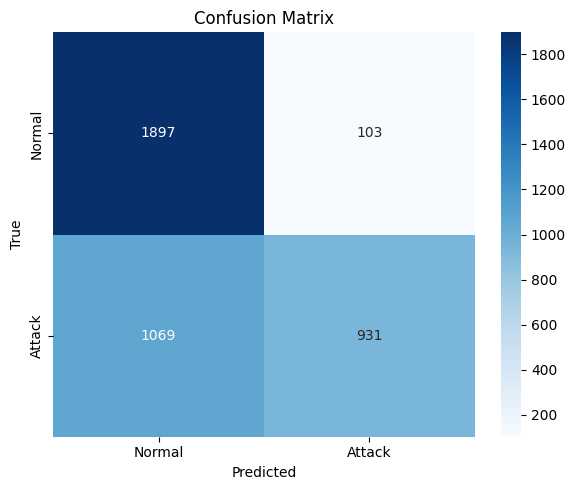

In [25]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_80000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_80000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '+')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 1, 64)     │     20,224 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 1, 64)     │     15,360 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1, 128)    │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 1, 128)    │          0 │ concatenate_3[0]… │
│ (Attention)         │                   │            │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_3[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,953 (179.50 KB)

 Trainable params: 45,953 (179.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning:

You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6676 - loss: 0.5770
Epoch 1: val_loss improved from inf to 0.53284, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-46-15.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.6677 - loss: 0.5770 - val_accuracy: 0.7102 - val_loss: 0.5328
Epoch 2/50
1685/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7081 - loss: 0.5329
Epoch 2: val_loss improved from 0.53284 to 0.52806, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-46-15.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7081 - loss: 0.5329 - val_accuracy: 0.7127 - val_loss: 0.5281
Epoch 3/50
1687/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7143 - loss: 0.5274
Epoch 3: val_loss improved from 0.52806 to 0.52394, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-46-15.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7143 - loss: 0.5274 - val_accuracy: 0.7102 - val_loss: 0.5239
Epoch 4/50
1687/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning:

You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


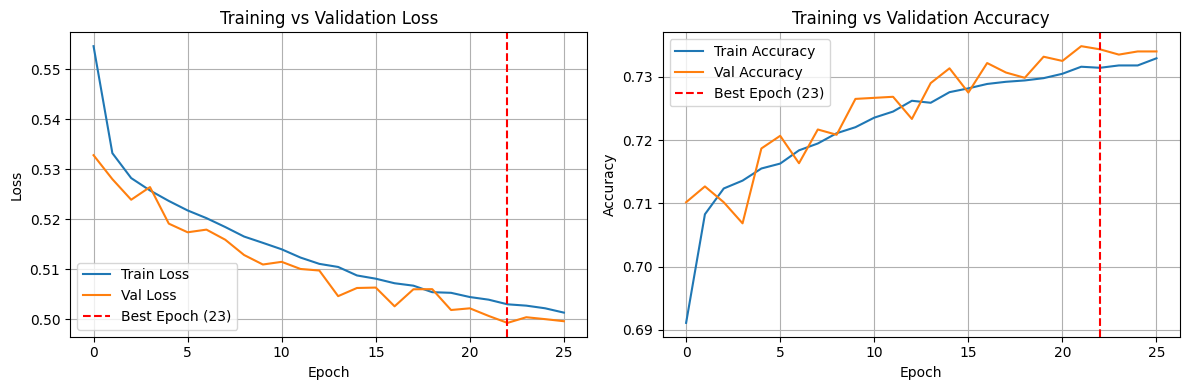

Early stopping triggered. Best epoch: 23, patience used: 3
Best model saved to: 14_LSTMGRU_ATT_mcp_2025-06-15_15-46-15.keras
Results saved to lstmgru_test_results.csv


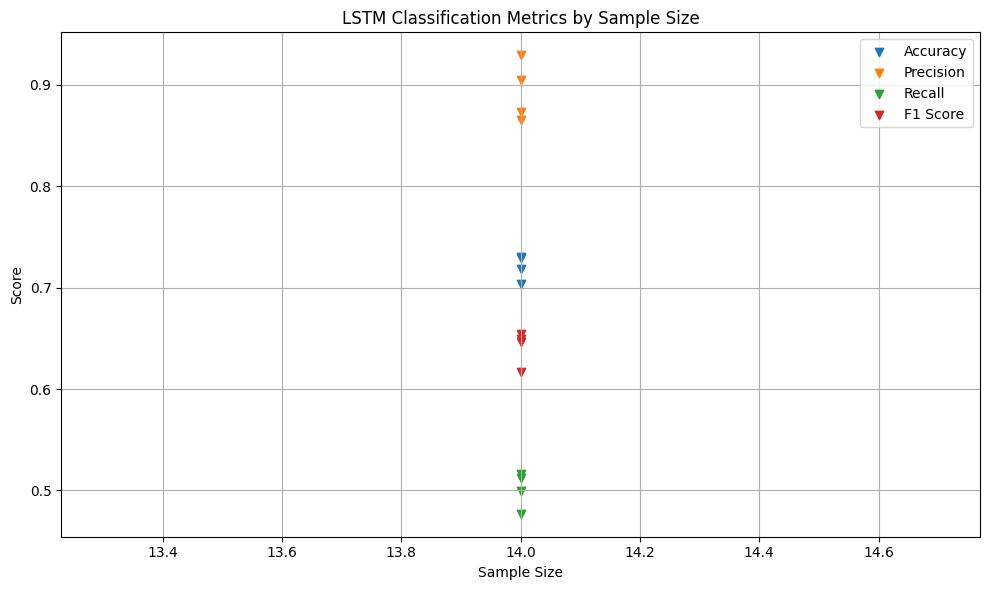

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
3,2025-06-15 15:53:53,LSTMGRU_ATT,veremi_stratified_120000.csv,14,453.88,23,0.7305,0.929236,0.499,0.649317,[[2886 114]\n [1503 1497]],58.8,1724.9,0.578882,0.000438


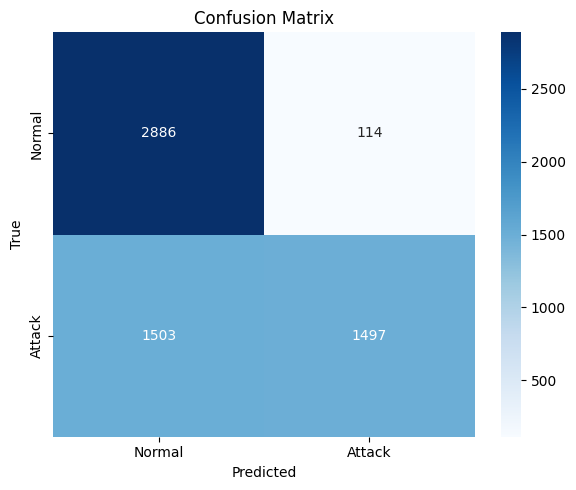

In [ ]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_120000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_120000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'v')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 1, 64)     │     20,224 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 1, 64)     │     15,360 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 1, 128)    │          0 │ lstm_4[0][0],     │
│ (Concatenate)       │                   │            │ gru_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 1, 128)    │          0 │ concatenate_4[0]… │
│ (Attention)         │                   │            │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_4[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         33 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,953 (179.50 KB)

 Trainable params: 45,953 (179.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning:

You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



2242/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6799 - loss: 0.5660
Epoch 1: val_loss improved from inf to 0.53499, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-53-56.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.6800 - loss: 0.5659 - val_accuracy: 0.7035 - val_loss: 0.5350
Epoch 2/50
2245/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7082 - loss: 0.5323
Epoch 2: val_loss improved from 0.53499 to 0.52941, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-53-56.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.7083 - loss: 0.5323 - val_accuracy: 0.7075 - val_loss: 0.5294
Epoch 3/50
2242/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7142 - loss: 0.5240
Epoch 3: val_loss improved from 0.52941 to 0.52715, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-53-56.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.7142 - loss: 0.5240 - val_accuracy: 0.7100 - val_loss: 0.5272
Epoch 4/50
2249/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning:

You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


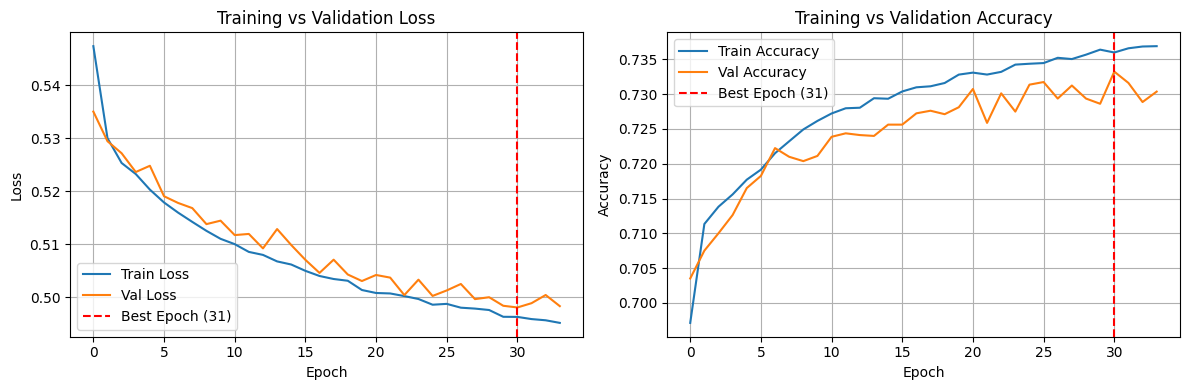

Early stopping triggered. Best epoch: 31, patience used: 3
Best model saved to: 14_LSTMGRU_ATT_mcp_2025-06-15_15-53-56.keras
Results saved to lstmgru_test_results.csv


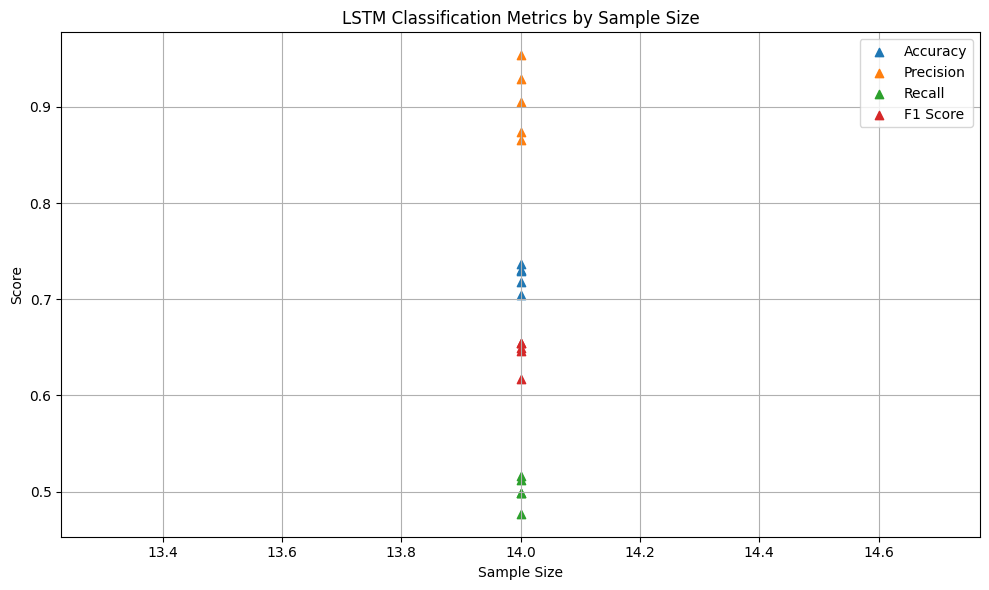

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
4,2025-06-15 16:05:22,LSTMGRU_ATT,veremi_stratified_160000.csv,14,682.79,31,0.737,0.953589,0.49825,0.654516,[[3903 97]\n [2007 1993]],56.3,1789.86,0.578885,0.000246


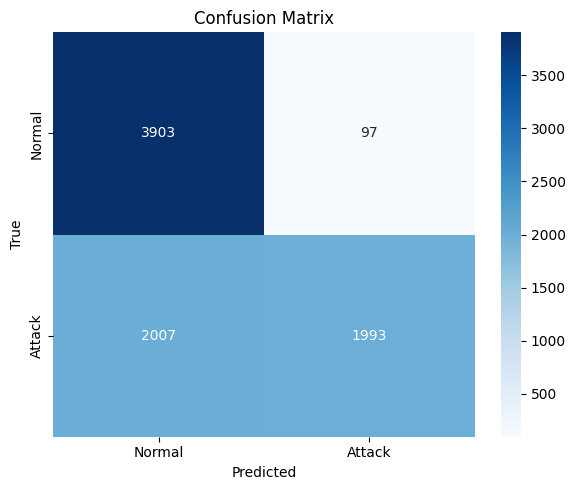

In [ ]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_160000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_160000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '^')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 1, 64)     │     20,224 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 1, 64)     │     15,360 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1, 128)    │          0 │ lstm_5[0][0],     │
│ (Concatenate)       │                   │            │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_5         │ (None, 1, 128)    │          0 │ concatenate_5[0]… │
│ (Attention)         │                   │            │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_5[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,953 (179.50 KB)

 Trainable params: 45,953 (179.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning:

You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



2812/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6807 - loss: 0.5644
Epoch 1: val_loss improved from inf to 0.52985, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_16-05-26.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.6807 - loss: 0.5644 - val_accuracy: 0.7093 - val_loss: 0.5299
Epoch 2/50
2807/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7084 - loss: 0.5307
Epoch 2: val_loss improved from 0.52985 to 0.52616, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_16-05-26.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.7084 - loss: 0.5307 - val_accuracy: 0.7091 - val_loss: 0.5262
Epoch 3/50
2811/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7148 - loss: 0.5247
Epoch 3: val_loss improved from 0.52616 to 0.52395, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_16-05-26.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.7148 - loss: 0.5247 - val_accuracy: 0.7159 - val_loss: 0.5240
Epoch 4/50
2810/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning:

You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


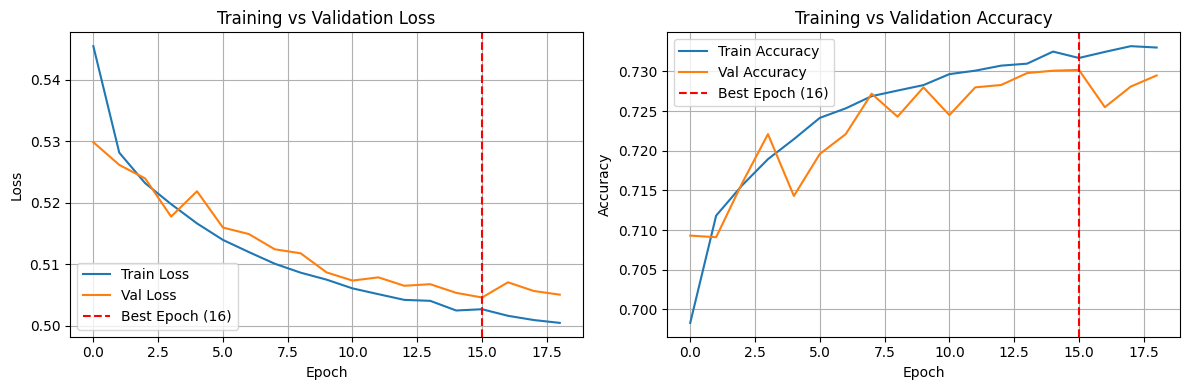

Early stopping triggered. Best epoch: 16, patience used: 3
Best model saved to: 14_LSTMGRU_ATT_mcp_2025-06-15_16-05-26.keras
Results saved to lstmgru_test_results.csv


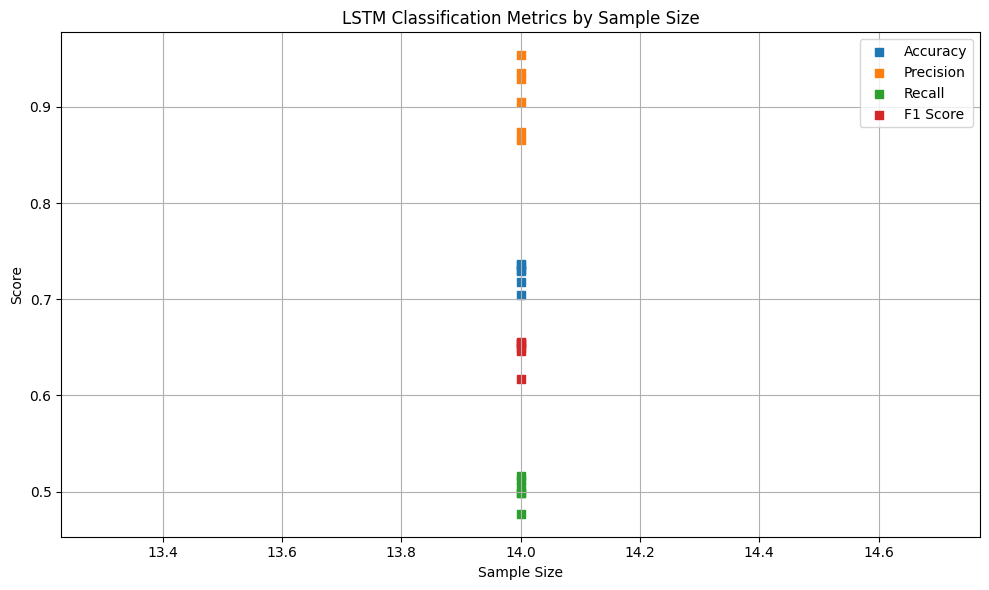

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
5,2025-06-15 16:15:06,LSTMGRU_ATT,veremi_stratified_200000.csv,14,575.69,16,0.7351,0.935532,0.505,0.655929,[[4826 174]\n [2475 2525]],3.0,1836.74,0.578885,0.000262


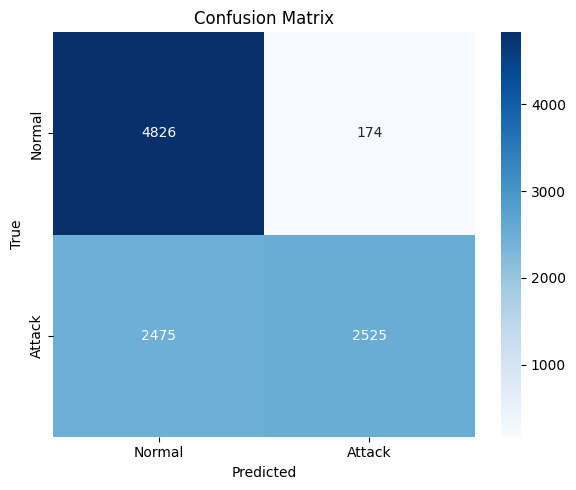

In [ ]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_200000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_200000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 's')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")

In [ ]:
from google.colab import files
files.download("/content/lstmgru_test_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from datetime import datetime

# Get current date and time
now = datetime.now()

# Print formatted datetime
print("Current date and time:", now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time: 2025-06-15 16:15:07
